In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

# Сигмоидальная активация

In [154]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x: [-6.         -5.87878788 -5.75757576 -5.63636364 -5.51515152]
y: [0.00247262 0.00279037 0.00314881 0.00355314 0.00400918]


Text(0, 0.5, 'sigmoid(x)')

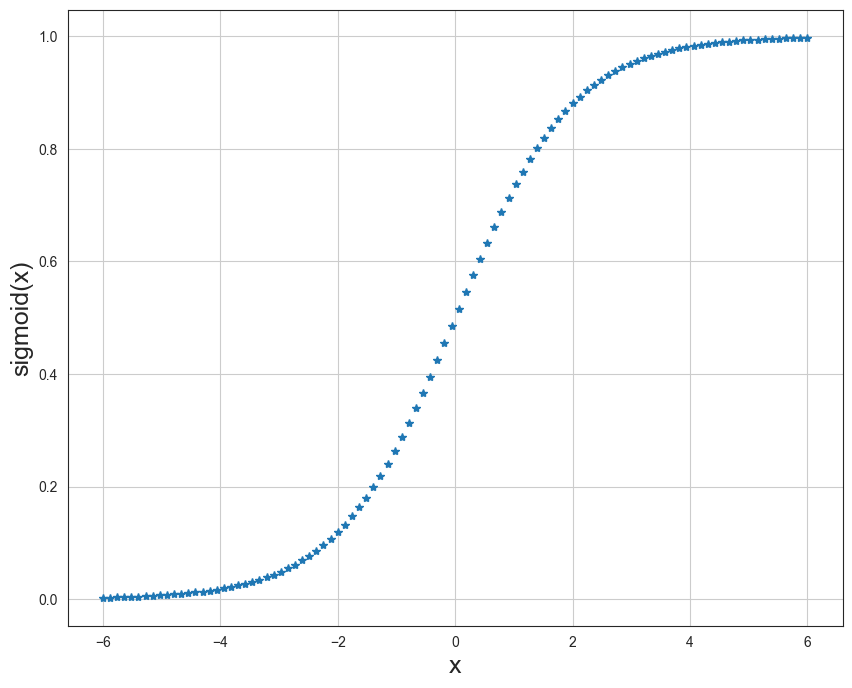

In [155]:
fig = plt.figure(figsize=(10, 8))

x = np.linspace(-6, 6, 100)
print('x:', x[:5])
y = sigmoid(x)
print('y:', y[:5])
plt.grid()
plt.plot(x, y, '*')

plt.xlabel('x', fontsize=18)
plt.ylabel('sigmoid(x)', fontsize=18)

# Функция потерь

Обучающую выборку можно рассматривать, как реализацию обобщённой схемы Бернулли (реальные ответы 0 или 1) - для каждого объекта генерируется случайная величина, которая с вероятностью p (своей для каждого объекта) принимает значение 1 и с вероятностью (1–p) – 0. Предпологаем, что мы как раз и строим нашу модель так, чтобы она генерировала правильные вероятности, но тогда можно записать функцию правдоподобия:

$$a_{i} = a(x_{i}|w)$$

Это прогноз алгоритма для точки данных $i$ с параметрами $w$.

$$p(y|X, w) = \prod_{i} p(y_{i}|x_{i}w) = \prod_{i} a_{i}^{y_{i}}(1-a_{i})^{(1-y_{i})} \to max$$

Откуда путем логарифмирования правдоподобия получаем, что максимизация функции правдоподобия эквивалентна минимизации:

$$\sum_{i} (-y_{i} log a_{i} - (1 - y_{i})log(1-a_{i}) ) \to min$$

Полученное выражение есть логистическая функция ошибки или кросс-энтропия для одного объекта i.

Кросс энтропия или логистическая функция потерь (logloss):

$$L = \frac{1}{n} \sum_{i} (-y_{i} log a_{i} - (1 - y_{i})log(1-a_{i}) ) \to min$$

В нашей реализации будет использован numpy, операции выше можно будет реализовать через скалярные перемножения векторов:

$$\sum_{i}-y_{i}log(a_{i}) = \vec{y}^{T}\vec{log(a)}$$

Где прогнозы алгоритма $a$ вычисляется по формуле:

$$a=\sigma{(w^{T}X)} = \frac{1}{1+e^{-w^{T}X}}$$


Учтем неприятное свойство логосса: если для объекта 1-го класса мы предсказываем нулевую вероятность принадлежности к этому классу или, наоборот, для объекта 0-го – единичную вероятность принадлежности к классу 1, то ошибка равна бесконечности! Таким образом, грубая ошибка на одном объекте сразу делает алгоритм бесполезным. По этой причине логлосс ограничивают каким-то большим числом (чтобы не связываться с бесконечностями) или добавляют под знак логарифма небольшое значение. В нашем сулчае добавим небольшой $\epsilon = 1*10^{-5}$ (не путать со случайной ошибкой).

In [156]:
def compute_cost(X, y, w):
    # кол-во элементов в выборке
    n = len(y)
    # прогноз алгоритма для всех точек
    a = sigmoid(X @ w)
    # небольшая константа, чтобы не связываться с бесконечностями в логарифме
    epsilon = 1e-5
    # логистическая функция потерь (см. формулу выше
    cost = (1/n)*(((-y).T @ np.log(a + epsilon))-((1-y).T @ np.log(1-a + epsilon)))
    return cost

# Градиентный спуск

Будем решать логистическую регрессию методом градиентного спуска. Этот метод используется для решения задачи бинарной классификации, который получает вероятность принадлежности к классу 1.

$$L(a, y) = Cross-entropy (a, y) = -ylog(a) - (1-y)log(1-a)$$

Откуда подставив выражение для $a$ (из формул выше):

$$a=\sigma{(w^{T}X)} = \frac{1}{1+e^{-w^{T}X}}$$

Получим правило для обновления параметров алгоритма методом градиентного спуска. Продифференцируем функцию потерть по параметрам:

$$\frac{\partial L}{\partial w} = X(a-y)$$

Тогда один шаг градиентного спуска будет выглядеть:

$$w_{t+1} = w_{t} - \alpha X(a-y)$$

где

* $w$ - веса
* $\alpha$ - скорость обучения (константа равная, например, 0.03)
* $t$ - номер итерации
* $y$ - реальные ответы (целевая)
* $a$ - прогноз алгоритма


In [157]:
def gradient_descent(X, y, w, learning_rate, iterations):
    # размер выборки
    n = len(y)
    # история потерь по шагам
    cost_history = np.zeros((iterations,1))
    for i in range(iterations):
        # шаг градиентного спуска в логистической регрессии (n для большей численной стабильности)
        
        w = w - (learning_rate/n) * (X.T @ (sigmoid(X @ w) - y)) # log-loss
        # w = w - learning_rate / (2 * n) * (-2 * X.T @ y + 2 * X.T @ sigmoid(X @ w)) # MSE
        
        # записываем историю потерь
        cost_history[i] = compute_cost(X, y, w)

    return (cost_history, w)

Когда мы сошлись к оптимальным параметрам можно использовать готовые параметры для предсказания вероятности отношения каждой точки к первому классу:

$$a=\sigma{(w^{T}X)} = \frac{1}{1+e^{-w^{T}X}}$$

In [158]:
# предсказываем с обученными весами w на заданных значениях X
def predict(X, w):
    return np.round(sigmoid(X @ w))

# Создание синтетических данных

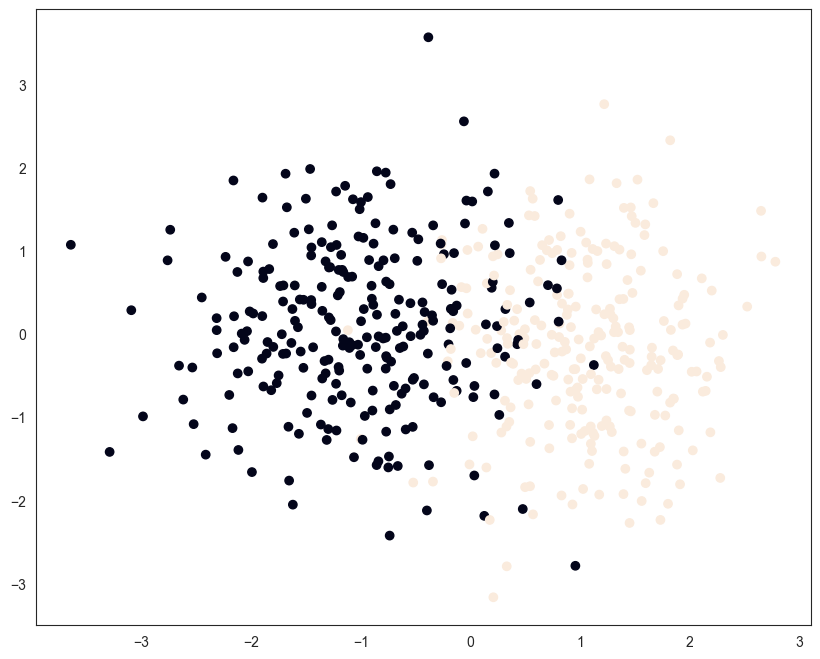

In [159]:
# Создаем 500 точек для двух классов
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1, random_state=123)

# для того, чтоб векторно перемножалось корректно
y = y[:,np.newaxis]

# размер фигуры
plt.figure(figsize=(10, 8))
# отображаем
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y)
# sns.set_style('white')
# sns.scatterplot(X,hue=y.reshape(-1))

In [160]:
y

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
    

# Инициализация параметров алгоритма

In [161]:
# размер выборки
n = len(y)
# вектор единиц добавляем в начало выборки для смещения (w_0)
X = np.hstack((np.ones((n,1)), X))

# размер признакового пространства - у нас 3
m = np.size(X,1)

# настраиваемые параметры, зададим нулями
w = np.zeros((m, 1))

print(w.shape)
w

(3, 1)


array([[0.],
       [0.],
       [0.]])

In [162]:
# смещения, коодината х, координата y
X

array([[ 1.        ,  0.35035256,  1.33745383],
       [ 1.        ,  1.28844157, -1.17893695],
       [ 1.        ,  1.30269273,  0.19021002],
       ...,
       [ 1.        , -1.7346257 ,  0.57779395],
       [ 1.        , -0.59013693, -1.14752541],
       [ 1.        , -0.73623429, -2.42483633]])

In [163]:
# кол-во итераций обновления
iterations = 1500
# скорость обучения
learning_rate = 0.03

In [164]:
# проверим, что Loss расчитывается верно
initial_cost = compute_cost(X, y, w)
initial_cost

array([[0.69312718]])

In [165]:
# проверим, что параметры обновляеются один раз проделав шаг град спуска (см. раздел град спуска)
w - (learning_rate/n) * (X.T @ (sigmoid(X @ w) - y))

array([[ 0.        ],
       [ 0.01531432],
       [-0.00205193]])

# Обучение

In [166]:
# обучаем с заданными параметрами
cost_history, w = gradient_descent(X, y, w, learning_rate, iterations)

In [167]:
# найденные оптимальные параметры
w

array([[-0.19475801],
       [ 2.85594761],
       [-0.25263503]])

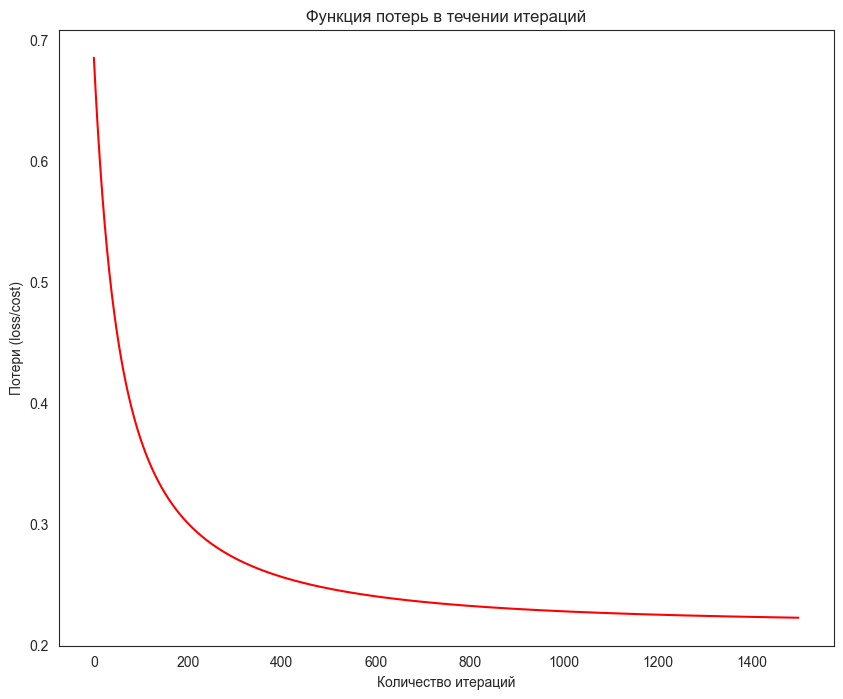

In [168]:
plt.figure(figsize=(10, 8))
sns.set_style('white')
plt.plot(range(len(cost_history)), cost_history, 'r')
plt.title("Функция потерь в течении итераций")
plt.xlabel("Количество итераций")
plt.ylabel("Потери (loss/cost)")
plt.show()

In [169]:
# посмотрим на качество на обучающем наборе
y_pred = predict(X, w)
score = float(sum(y_pred == y))/ float(len(y))

print(score)

0.904


C:\Users\merku\AppData\Local\Temp\ipykernel_28408\4237266537.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(sum(y_pred == y))/ float(len(y))


# Бонус: визуализируем

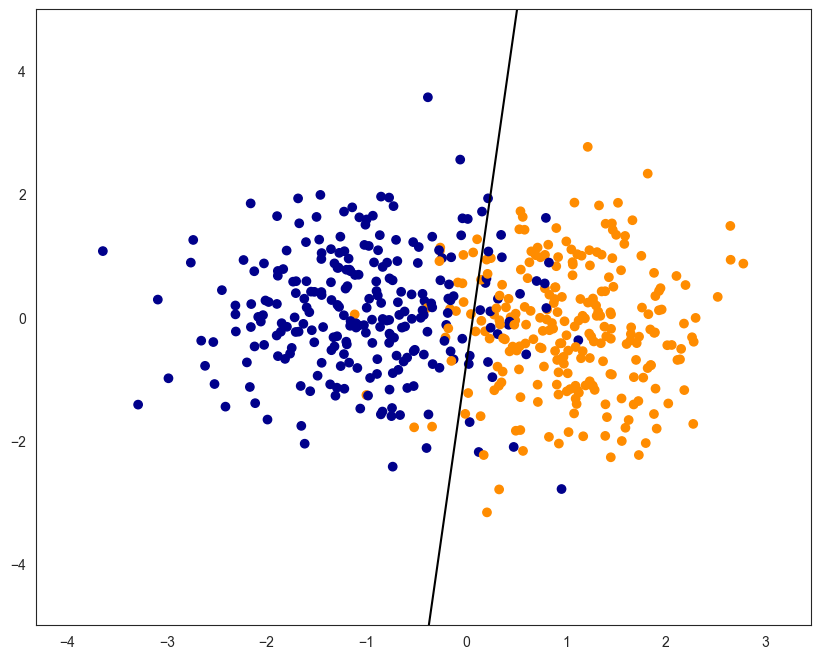

In [170]:
slope = -(w[1] / w[2])
intercept = -(w[0] / w[2])

plt.figure(figsize=(10, 8))
plt.scatter(X[:,1],X[:,2],c=list(map(lambda x: 'darkblue' if x==0 else 'darkorange', y)))

ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = intercept + (slope * x_vals)
plt.ylim((-5, 5))
plt.plot(x_vals, y_vals, c="k")